<a href="https://colab.research.google.com/github/caleb-vicente/RL_tutorials/blob/dev/Traveling_Salesman_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   We are following the tutorial of page: https://ekimetrics.github.io/blog/2021/11/03/tsp/
*   How to create a new gym environment: https://towardsdatascience.com/beginners-guide-to-custom-environments-in-openai-s-gym-989371673952
*   Whole solution to the problem can be found here: https://github.com/TheoLvs/reinforcement-learning/blob/master/5.%20Delivery%20Optimization/Optimizing%20delivery%20with%20Reinforcement%20Learning.ipynb

In [1]:
!pip install gymnasium==0.26.1
!pip install "ray[rllib]" torch
!pip install moviepy==1.0.3
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gymnasium-0.26.1-py3-none-any.whl (830 kB)
  Attempting uninstall: gymnasium
    Found existing installation: Gymnasium 0.26.3
    Uninstalling Gymnasium-0.26.3:
      Successfully uninstalled Gymnasium-0.26.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Gymnasium-0.26.3-py3-none-any.whl (836 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.26.1
    Uninstalling gymnasium-0.26.1:
      Successfully uninstalled gymnasium-0.26.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Create Simple Environment

In [2]:
# ===============================================================================================================================================
# This enviroment has been obtained from: https://github.com/TheoLvs/reinforcement-learning/blob/master/5.%20Delivery%20Optimization/delivery.py
# ===============================================================================================================================================

# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

class DeliveryEnvironment(object):
    def __init__(self,n_stops = 10,max_box = 10,method = "distance",**kwargs):

        print(f"Initialized Delivery Environment with {n_stops} random stops")
        print(f"Target metric for optimization is {method}")

        # Initialization
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.max_box = max_box
        self.stops = []
        self.method = method

        # Generate stops
        self._generate_constraints(**kwargs)
        self._generate_stops()
        self._generate_q_values()
        self.render()

        # Initialize first point
        self.reset()


    def _generate_constraints(self,box_size = 0.2,traffic_intensity = 5):

        if self.method == "traffic_box":

            x_left = np.random.rand() * (self.max_box) * (1-box_size)
            y_bottom = np.random.rand() * (self.max_box) * (1-box_size)

            x_right = x_left + np.random.rand() * box_size * self.max_box
            y_top = y_bottom + np.random.rand() * box_size * self.max_box

            self.box = (x_left,x_right,y_bottom,y_top)
            self.traffic_intensity = traffic_intensity 



    def _generate_stops(self):

        if self.method == "traffic_box":

            points = []
            while len(points) < self.n_stops:
                x,y = np.random.rand(2)*self.max_box
                if not self._is_in_box(x,y,self.box):
                    points.append((x,y))

            xy = np.array(points)

        else:
            # Generate geographical coordinates
            xy = np.random.rand(self.n_stops,2)*self.max_box

        self.x = xy[:,0]
        self.y = xy[:,1]


    def _generate_q_values(self,box_size = 0.2):

        # Generate actual Q Values corresponding to time elapsed between two points
        if self.method in ["distance","traffic_box"]:
            xy = np.column_stack([self.x,self.y])
            self.q_stops = cdist(xy,xy)
        elif self.method=="time":
            self.q_stops = np.random.rand(self.n_stops,self.n_stops)*self.max_box
            np.fill_diagonal(self.q_stops,0)
        else:
            raise Exception("Method not recognized")
    

    def render(self,return_img = False):
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Delivery Stops")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")
            
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")


        if hasattr(self,"box"):
            left,bottom = self.box[0],self.box[2]
            width = self.box[1] - self.box[0]
            height = self.box[3] - self.box[2]
            rect = Rectangle((left,bottom), width, height)
            collection = PatchCollection([rect],facecolor = "red",alpha = 0.2)
            ax.add_collection(collection)


        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()



    def reset(self):

        # Stops placeholder
        self.stops = []

        # Random first stop
        first_stop = np.random.randint(self.n_stops)
        self.stops.append(first_stop)

        return first_stop


    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination

        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,reward,done
    

    def _get_state(self):
        return self.stops[-1]


    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self,state,new_state):
        base_reward = self.q_stops[state,new_state]

        if self.method == "distance":
            return base_reward
        elif self.method == "time":
            return base_reward + np.random.randn()
        elif self.method == "traffic_box":

            # Additional reward correspond to slowing down in traffic
            xs,ys = self.x[state],self.y[state]
            xe,ye = self.x[new_state],self.y[new_state]
            intersections = self._calculate_box_intersection(xs,xe,ys,ye,self.box)
            if len(intersections) > 0:
                i1,i2 = intersections
                distance_traffic = np.sqrt((i2[1]-i1[1])**2 + (i2[0]-i1[0])**2)
                additional_reward = distance_traffic * self.traffic_intensity * np.random.rand()
            else:
                additional_reward = np.random.rand()

            return base_reward + additional_reward


    @staticmethod
    def _calculate_point(x1,x2,y1,y2,x = None,y = None):

        if y1 == y2:
            return y1
        elif x1 == x2:
            return x1
        else:
            a = (y2-y1)/(x2-x1)
            b = y2 - a * x2

            if x is None:
                x = (y-b)/a
                return x
            elif y is None:
                y = a*x+b
                return y
            else:
                raise Exception("Provide x or y")


    def _is_in_box(self,x,y,box):
        # Get box coordinates
        x_left,x_right,y_bottom,y_top = box
        return x >= x_left and x <= x_right and y >= y_bottom and y <= y_top


    def _calculate_box_intersection(self,x1,x2,y1,y2,box):

        # Get box coordinates
        x_left,x_right,y_bottom,y_top = box

        # Intersections
        intersections = []

        # Top intersection
        i_top = self._calculate_point(x1,x2,y1,y2,y=y_top)
        if i_top > x_left and i_top < x_right:
            intersections.append((i_top,y_top))

        # Bottom intersection
        i_bottom = self._calculate_point(x1,x2,y1,y2,y=y_bottom)
        if i_bottom > x_left and i_bottom < x_right:
            intersections.append((i_bottom,y_bottom))

        # Left intersection
        i_left = self._calculate_point(x1,x2,y1,y2,x=x_left)
        if i_left > y_bottom and i_left < y_top:
            intersections.append((x_left,i_left))

        # Right intersection
        i_right = self._calculate_point(x1,x2,y1,y2,x=x_right)
        if i_right > y_bottom and i_right < y_top:
            intersections.append((x_right,i_right))

        return intersections


<ipython-input-2-0fe864543ac7>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


# Create same environmet with gym

In [3]:
import gymnasium
from gymnasium import spaces

class DeliveryEnv(gymnasium.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, n_stops=10, max_box=10, method="distance", **kwargs):
        self.n_stops = n_stops
        self.max_box = max_box
        self.method = method
        self.kwargs = kwargs
        self.delivery_env = DeliveryEnvironment(n_stops=n_stops, max_box=max_box, method=method, **kwargs)
        self.action_space = spaces.Discrete(n_stops)
        self.observation_space = spaces.Discrete(n_stops)
        self.state = None

    def step(self, action):
        state, reward, done = self.delivery_env.step(action)
        self.state = state
        if done:
            reward = -100
        return state, reward, done

    def reset(self):
        self.state = self.delivery_env.reset()
        return self.state

    def render(self, mode='human', close=False):
        return self.delivery_env.render(return_img=True)



Initialized Delivery Environment with 100 random stops
Target metric for optimization is distance


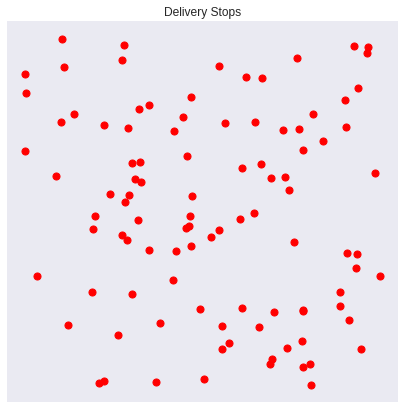

In [4]:
env = DeliveryEnv(n_stops=100, max_box=10, method="distance")

In [5]:
env.action_space

Discrete(100)

In [9]:
env.step(1)

(1, 9.214996684794462, False)

## Training algorithm RL

In [7]:
import ray

ray.init(num_cpus=3, ignore_reinit_error=True, log_to_driver=False)

2023-03-26 13:36:46,894	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


In [8]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.tune.registry import register_env
from ray import tune
from ray import air
from ray import tune
import os

# Register the custom environment
def env_creator(env_config):
    return DeliveryEnv(n_stops=env_config['n_stops'])

register_env("DeliveryEnv-v0", env_creator)

config = DQNConfig()
config.training(lr=tune.grid_search([0.001, 0.0001]))

# Set the config object's env.
config = config.environment(env='DeliveryEnv-v0', env_config={'n_stops': 150})
config = config.framework("torch")
# Use to_dict() to get the old-style python config dict
# when running with tune.
tuner = tune.Tuner(  # doctest: +SKIP
     "DQN",
     run_config=air.RunConfig(stop= {"training_iteration": 8},
                              local_dir="./results"),
     param_space=config.to_dict(),
)

results = tuner.fit()

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


2023-03-26 13:37:25,589	ERROR trial_runner.py:1062 -- Trial DQN_DeliveryEnv-v0_47d3c_00000: Error processing event.
ray.tune.error._TuneNoNextExecutorEventError: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/execution/ray_trial_executor.py", line 1276, in get_next_executor_event
    future_result = ray.get(ready_future)
  File "/usr/local/lib/python3.9/dist-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/ray/_private/worker.py", line 2382, in get
    raise value
  File "python/ray/_raylet.pyx", line 1166, in ray._raylet.task_execution_handler
  File "python/ray/_raylet.pyx", line 1072, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 805, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 972, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 621, in ray._raylet.store_task_

Trial name,trial_id
DQN_DeliveryEnv-v0_47d3c_00000,47d3c_00000
DQN_DeliveryEnv-v0_47d3c_00001,47d3c_00001


2023-03-26 13:37:25,608	ERROR ray_trial_executor.py:930 -- An exception occurred when trying to stop the Ray actor:Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/execution/ray_trial_executor.py", line 921, in _resolve_stop_event
    ray.get(future, timeout=timeout)
  File "/usr/local/lib/python3.9/dist-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/ray/_private/worker.py", line 2382, in get
    raise value
  File "python/ray/_raylet.pyx", line 1166, in ray._raylet.task_execution_handler
  File "python/ray/_raylet.pyx", line 1072, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 805, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 972, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 621, in ray._raylet.store_task_errors
ray.exceptions.RayActorError: The actor died becau

## Apply Genetic Algorithm

## Increase Environment